In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
import hiddenlayer as hl
from torchviz import make_dot

In [7]:
spam = pd.read_csv("data/chap5/spambase.csv")
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [10]:
## 计算垃圾邮件和非垃圾邮件
pd.value_counts(spam.label)

0    2788
1    1813
Name: label, dtype: int64

In [28]:
## 将数据随机切分为训练集和测试集
X = spam.iloc[:,0:57].values
y = spam.label.values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=123)

In [29]:
## 对数据的前57列特征进行数据标准化处理
scales = MinMaxScaler(feature_range=(0,1))
X_train_s = scales.fit_transform(X_train)
X_test_s = scales.fit_transform(X_test)

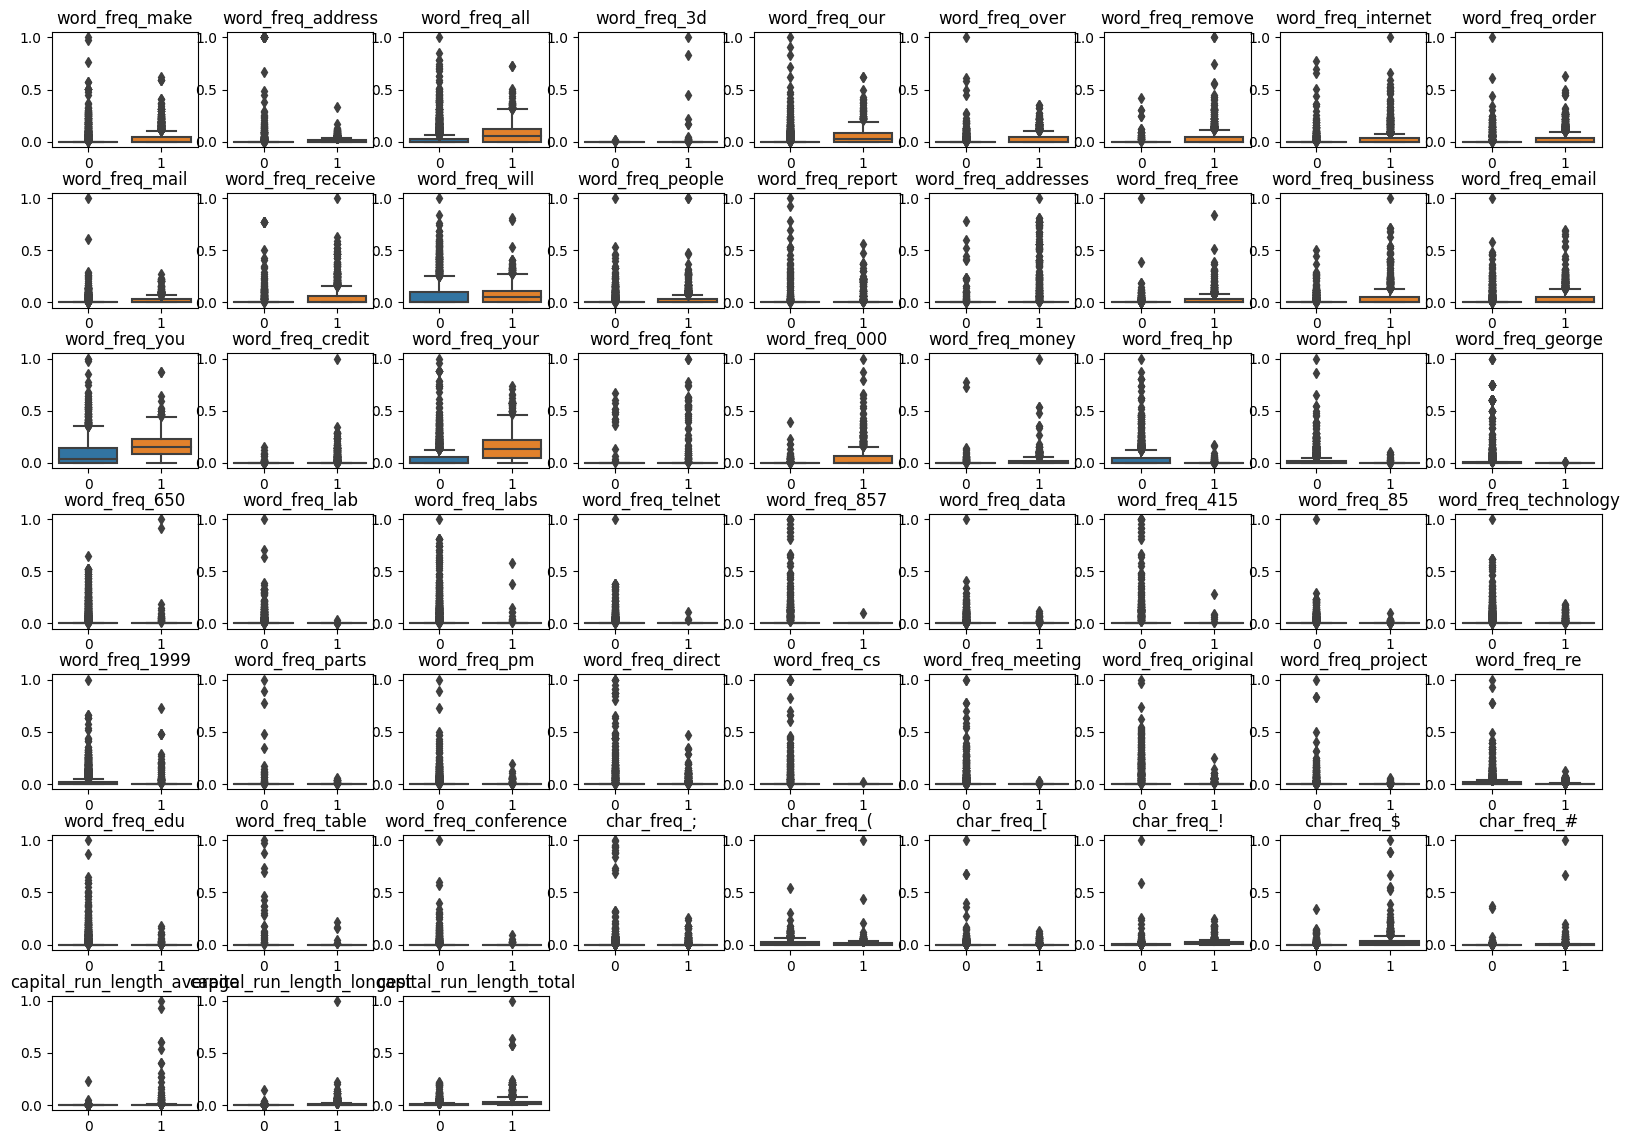

In [30]:
colname = spam.columns.values[:-1]
plt.figure(figsize=(20,14))
for ii in range(len(colname)):
    plt.subplot(7,9,ii+1)
    sns.boxplot(x = y_train, y = X_train_s[:, ii])
    plt.title(colname[ii])
plt.subplots_adjust(hspace=0.4)
plt.show()


In [31]:
## 全连接网络
class MLPclassifica(nn.Module):
    def __init__(self):
        super(MLPclassifica,self).__init__()
        ## 定义第一个隐藏层
        self.hidden1 = nn.Sequential(
            nn.Linear(
                in_features=57, ## 第一个隐藏层的输入，数据的特征数
                out_features=30, ## 第一个隐藏层的输出，神经元的数量
                bias=True, ## 默认会有偏置
            ),
            nn.ReLU()
        )

        ## define senond hidden layer
        self.hidden2 = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU()
        )

        ## class layer
        self.classifica = nn.Sequential(
            nn.Linear(10,2),
            nn.Sigmoid()
        )

    def forward(self, x):
        fc1 = self.hidden1(x)
        fc2 = self.hidden2(fc1)
        output = self.classifica(fc2)

        ##  输出为两个隐藏层和输出层
        return fc1, fc2, output

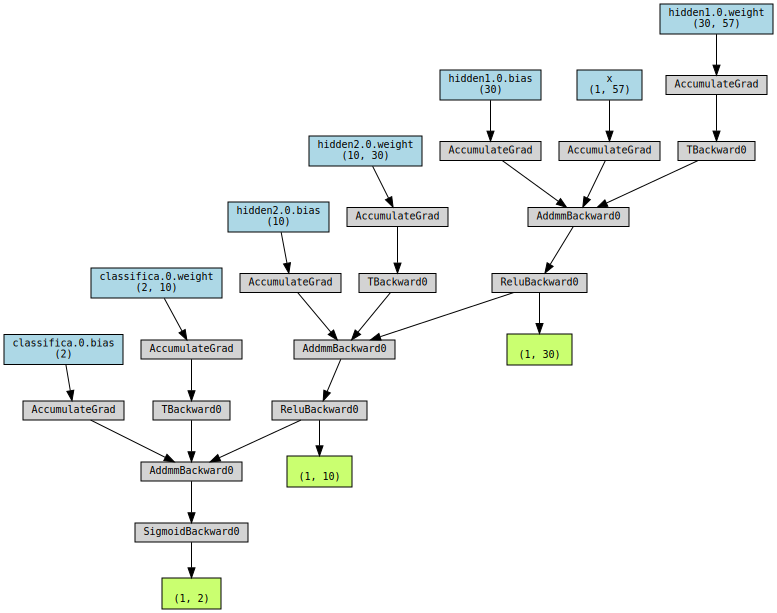

In [32]:
## 输出网络结构
mlpc = MLPclassifica()
## use make_dot to make the layer visual
x = torch.randn(1,57).requires_grad_(True)
y = mlpc(x)
Mymlpcvis = make_dot(y, params=dict(list(mlpc.named_parameters()) + [('x',x)]))
Mymlpcvis

In [33]:
## 将数据转换为张量
X_train_nots = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.int64))
X_test_nots = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.int64))

## 训练集转化为张量后，使用TensorDataset 将X和Y整理到一起
train_data_nots = Data.TensorDataset(X_train_nots, y_train_t)
## 定义一个数据加载器，将训练数据集进行批量处理
train_nots_loader = Data.DataLoader(
    dataset=train_data_nots, ## 使用的数据集
    batch_size=64, ## 批处理样本大小
    shuffle=True,  ## 每次迭代前打乱数据
    num_workers=1,
)

In [35]:
## 定义优化器
optimizer = torch.optim.Adam(mlpc.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss() ## 二分类损失函数
## 记录训练过程中的指标
history1 = hl.History()
## 使用Canvas进行可视化
canvasl = hl.Canvas()
print_step = 25
## 对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(15):
    ## 对训练数据的加载其进行迭代计算
    for step, (b_x, b_y) in enumerate(train_nots_loader):
        ## 计算每个batch的损失
        _,_,output = mlpc(b_x)  ## MLP 在训练batch 上的输出
        train_loss = loss_func(output, b_y) ## 二分类交叉熵损失函数
        optimizer.zero_grad()             ### 每个迭代步的梯度初始化为0
        train_loss.backward()           ## 损失的后向传播，计算梯度
        optimizer.step()      ## 使用梯度进行优化
        niter = epoch*len(train_nots_loader)+step+1

        ## 计算每经过print_step 次迭代后的输出
        if niter % print_step == 0:
            _,_,output = mlpc(X_test_nots)
            _,pre_lab = torch.max(output,1)
            test_accuracy = accuracy_score(y_test, pre_lab)
            ## 为history添加epoch,损失和精度
            history1.log(niter, train_loss=train_loss, test_accuracy=test_accuracy)

            ## 使用两个图像可视化损失函数和精度
            with canvasl:
                canvasl.draw_plot(history1["train_loss"])
                canvasl.draw_plot(history1["test_accuracy"])

NameError: name 'train_loader' is not defined